# Preperation

In [1]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten,MaxoutDense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconv2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
import random, sys, keras
import pickle as cPickle
import cv2
import glob
from keras.models import Model
from IPython import display

sys.path.append("../common")
from keras.utils import np_utils
from tqdm import tqdm


Using TensorFlow backend.
/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# From Google "InMyCircle"

In [18]:
def extract_imgs_from_circle(raw, setname, size=72):
    for i in range(1,11):
        for j in range(10):
            subimg = raw[i*size:(i+1)*size, j*size:(j+1)*size, :]
            plt.imsave("GAN_DS_%s/img_%d_%d_%f.png"%(setname, i,j, np.random.random()), subimg)   

In [10]:
raw2 = plt.imread("GAN-DS2.png")

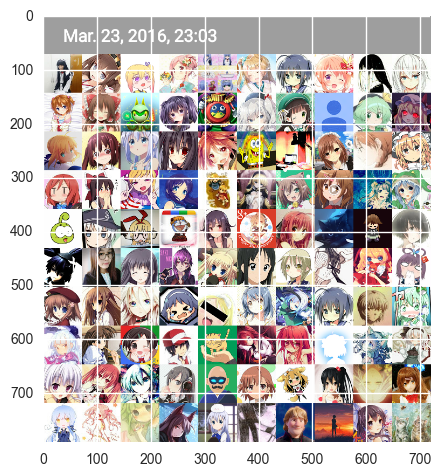

In [12]:
plt.imshow(raw2)

In [13]:
raw3 = plt.imread("GAN-DS3.png")

In [15]:
raw3.shape

(792, 720, 4)

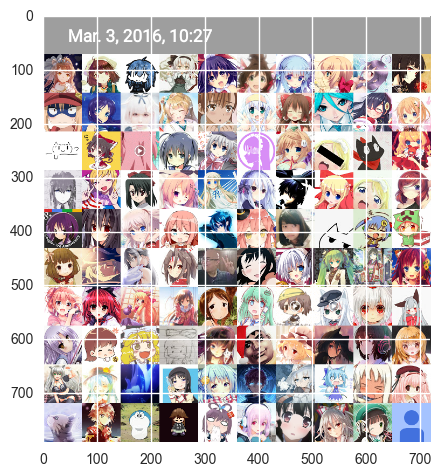

In [14]:
plt.imshow(raw3)

In [16]:
raw4 = plt.imread("GAN-DS4.png")

In [20]:
extract_imgs_from_circle(raw2, "clustering")
extract_imgs_from_circle(raw3, "clustering")
extract_imgs_from_circle(raw4, "clustering")

# Read from folder

In [21]:
# TODO: keep copying from neighbour
imageset = np.stack([plt.imread(fn) for fn in glob.glob("GAN_DS_clustering/*.png")])

In [22]:
imageset = imageset[:,:,:,:3]

In [23]:
imageset.shape

(300, 72, 72, 3)

# Dimention reduction & Clustering

## PCA

In [25]:
X = imageset.copy()

In [28]:
X = X.reshape((X.shape[0],-1))

In [34]:
X.shape

(300, 15552)

In [26]:
from sklearn.decomposition import PCA
pca95 = PCA(0.95)
pca90 = PCA(0.9)

In [32]:
X_95 = pca95.fit_transform(X)

In [33]:
X_95.shape

(300, 171)

In [35]:
X_90 = pca90.fit_transform(X)
X_90.shape

(300, 119)

In [36]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [39]:
for i in range(2,9):
    km = KMeans(i)
    km.fit(X_95)
    print("i=%d"%i, "score=%f"%silhouette_score(X_95, km.labels_))

i=2 score=0.181472
i=3 score=0.099648
i=4 score=0.106408
i=5 score=0.086888
i=6 score=0.081905
i=7 score=0.084417
i=8 score=0.038882


In [40]:
for i in range(2,9):
    km = KMeans(i)
    km.fit(X_90)
    print("i=%d"%i, "score=%f"%silhouette_score(X_95, km.labels_))

i=2 score=0.180794
i=3 score=0.102557
i=4 score=0.109788
i=5 score=0.094980
i=6 score=0.083072
i=7 score=0.057417
i=8 score=0.030000


In [42]:
km2 = KMeans(2)
km2.fit(X_95)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [56]:
def save_cluster_results(X,km,fn):
    # make folders
    for label in range(km.n_clusters):
        folder = "%s/cluster_%d"%(fn,label)
        if not os.path.exists(folder):
            os.makedirs(folder)
    for img,label in zip(X,km.labels_):
        plt.imsave("%s/cluster_%d/img_%f.png"%(fn,label,np.random.random()), img)


In [57]:
save_cluster_results(imageset, km2, "km2")

## YCrCb&PCA

In [72]:
X = imageset.copy()
X_y = np.zeros_like(X)
for i in range(X.shape[0]):
    X_y[i] = cv2.cvtColor(X[i], cv2.COLOR_RGB2YCrCb)

In [76]:
X = X.reshape((X.shape[0],-1))
X.shape

(300, 15552)

In [77]:
pca95 = PCA(0.95)
X_95 = pca95.fit_transform(X)
for i in range(2,9):
    km = KMeans(i)
    km.fit(X_95)
    print("i=%d"%i, "score=%f"%silhouette_score(X_95, km.labels_))

i=2 score=0.180794
i=3 score=0.103222
i=4 score=0.102717
i=5 score=0.056703
i=6 score=0.080564
i=7 score=0.048605
i=8 score=0.051561


In [80]:
km6 = KMeans(6)
km6.fit(X_95)
save_cluster_results(imageset, km6, "km6_YCrCb_2")

In [81]:
imageset = np.stack([plt.imread(fn) for fn in glob.glob("km6_YCrCb_2/*/*.png")])

In [83]:
imageset = imageset[:,:,:,:3]

## HOG&PCA

In [ ]:
from ski

# Augment

In [84]:
X_f = np.zeros_like(imageset)
for i in range(len(X_f)):
    X_f[i] = cv2.flip(imageset[i],1)
X = np.vstack([X_f,imageset])

# Save

In [85]:
np.save("GAN_DS_YCrCb_km6.npy", X)